
 # Apartment Pricing Regression – EDA, Preprocessing and Feature Engineering

## Overview
We made some initial research about the Russian house market to explore which features have the most impact on the house prices in Moscow. Thereby, we found the following papers on Google Scholar that helped us to get a better understanding of the situation:
- https://www.researchgate.net/publication/227488895_The_price_of_Moscow_apartments
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3374436


Moreover we found an old kaggle competition related to house price predictions in Moscow which provided some geographic-related data (restaurants, universities, sport-facilities, etc.):
- https://www.kaggle.com/c/sberbank-russian-housing-market/data 
- https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/32201

This dataset did not include the coordinates of the apartments in it, but this community member provided them:
- https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/33510

As a result of studying these papers and the old kaggle competition we decided to include some additional features which will be described in the Feature Engineering section.

## Loading data

In [1]:
import sys
sys.path.append('/proj/ciptmp/ny70konu/python3.9/site-packages')

import numpy as np
import pandas as pd
import geopandas as gp
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.neighbors import BallTree, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeCV, BayesianRidge
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.metrics.pairwise import haversine_distances
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

from lime import lime_tabular

pd.options.mode.chained_assignment = None

In [2]:
# Reading train/test data
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")
metro_stations = pd.read_csv("data/metro_stations.csv")

# External datasources
sub_area_centers = pd.read_csv("data/sberbank_sub_areas.csv")
sub_areas = gp.read_file('data/mo_kag_SRHM.shp')
sberbank_data = pd.read_csv("data/sberbank.csv")
sberbank_coordinates = pd.read_csv("data/sberbank_coordinates.csv")

sberbank_data = pd.merge(sberbank_data, sberbank_coordinates.set_index('id'), how='left', left_on='id', right_index=True)
sberbank_data = sberbank_data.rename(columns={"lat": "latitude", "lon": "longitude"})

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
print("Amount of training samples: ", len(train_df))
print("Amount of test samples: ", len(test_df))

# Merge train and test data
all_data = pd.concat([train_df, test_df])
all_data.describe()

Amount of training samples:  23285
Amount of test samples:  9937


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,20450.000000,2.328500e+04,33222.000000,26268.000000,27321.000000,33222.000000,33222.000000,8212.000000,17111.000000,27633.000000,...,33067.000000,32054.000000,27579.000000,33222.000000,32685.000000,32685.000000,32685.000000,23567.000000,20985.000000,21831.000000
mean,1.855208,2.355617e+07,74.658347,12.646894,38.961378,9.033773,2.193396,1.038602,3.399897,0.749177,...,4.655276,2002.583391,2.213750,17.758082,0.403335,0.928285,0.744103,0.567785,0.793424,0.164995
std,1.089435,5.264393e+07,57.989504,6.660294,31.915799,8.216781,1.085552,0.346312,12.489861,0.790536,...,3.155880,23.156363,1.034136,11.074147,0.490574,0.258019,0.436371,0.558527,0.404858,0.551502
min,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,...,2.000000,1989.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,1.064500e+07,59.700000,10.700000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,...,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,2.050000e+07,85.000000,15.600000,45.400000,12.000000,3.000000,1.000000,3.000000,1.000000,...,7.000000,2019.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,350.000000,4.000000,...,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


## Exploratory Data Analysis (EDA)
We extensively explorated the data, both single features and relation between them. We derived hypotheses from our findings and decided whether to keep data that seemed unintuitive at first, or whether there is predictive power in it.



### Analyze Target Distribution
To avoid predicting negative values, the target variable was log-transformed before before fitting our models and computing the prediction error. This happens through using the TransformedTargetRegressor when building the model.

Thr results are the following price ranges:

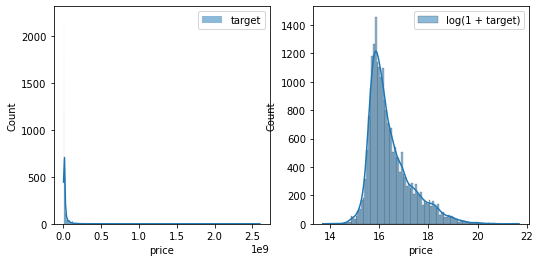

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend();

### Analyzing Missing Data

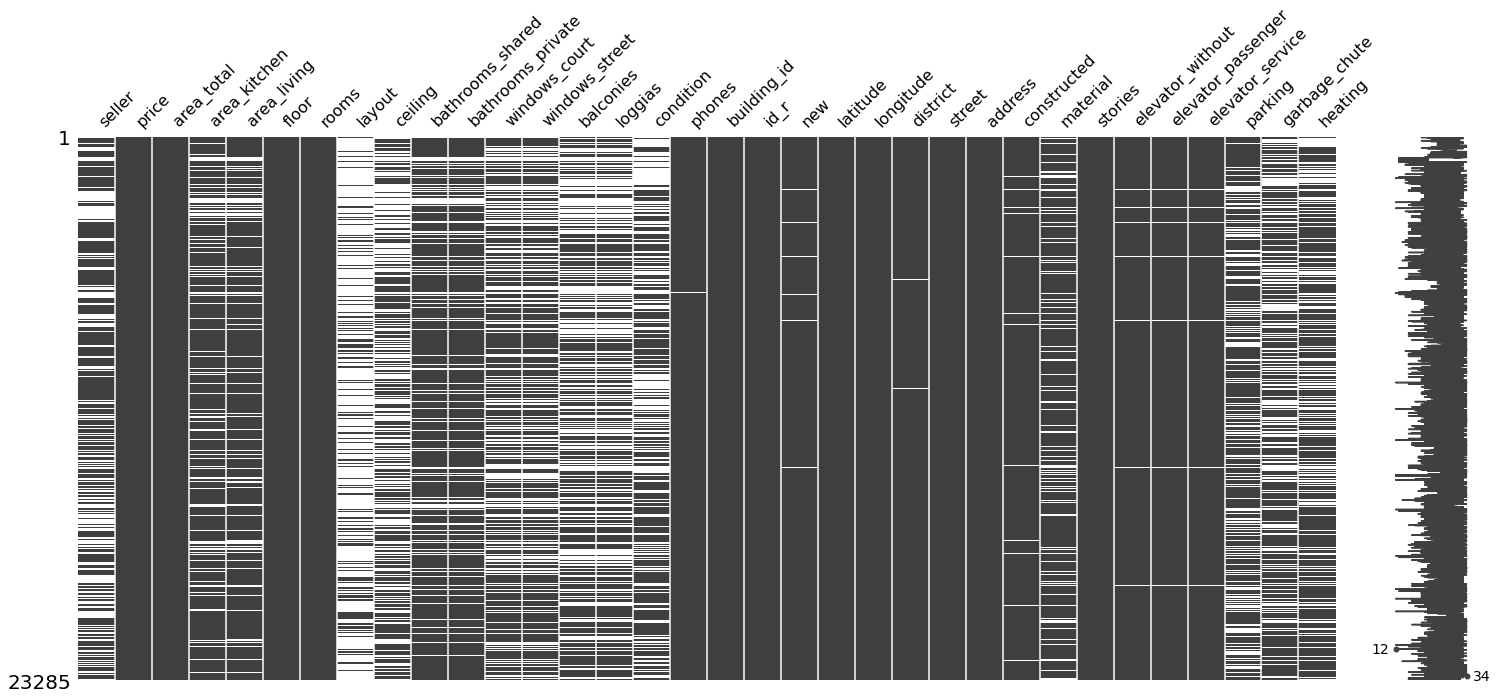

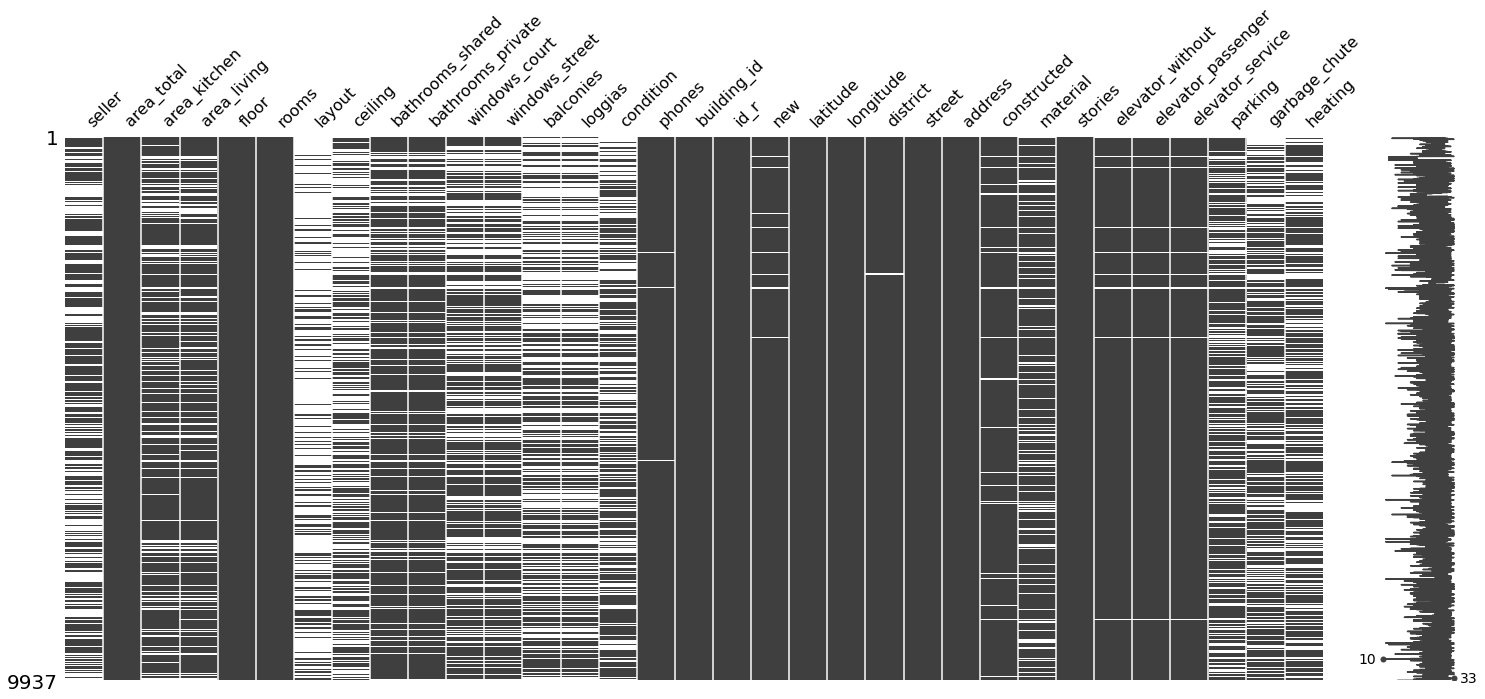

In [22]:
msno.matrix(train_df)
msno.matrix(test_df);

Analyzing the missing values, one can see that some features have more than 70% of missing values. We tried out different imputation strategies on the whole feature set to deal with that: 
- Imputing numerical features with mean/ median and catagorical features with most_frequent
- KNN imputation: Choosing the most frequent value of the k nearest neighbors in the hyperspace for imputation
- Iterative imputation: Estimates the missing values of each feature from all the other features
- Constant imputation: Imputing missing values with -999. This was chosen since the value does not appear in the value set of any feature.

In [3]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [9]:
y = train_df.price
X = train_df.drop("price", axis=1)
X['address'] = LabelEncoder().fit_transform(X['address'])
X['street'] = LabelEncoder().fit_transform(X['street'])

np.random.seed(42)

model_lgbm = LGBMRegressor(max_depth=6, n_estimators=1200, learning_rate=0.1)
trans_lgbm = TransformedTargetRegressor(regressor=model_lgbm, func=np.log1p, inverse_func=np.expm1)


# Constant Imputer
pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value=-999), trans_lgbm)
print("Running ConstantImputer")
ci_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Simple Imputer
categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating", "street", "address"]
numerical_columns = train_df.drop(categorical_columns + ["price"], axis=1).columns

imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), numerical_columns),
        ('cat', SimpleImputer(strategy="most_frequent"), categorical_columns)
])

pipe = make_pipeline(imputer, trans_lgbm)
print("Running SimpleImputer")
si_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Iterative Imputer
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge()]:
    print("Running IterativeImputer", estimator.__class__.__name__)
    pipe = make_pipeline(IterativeImputer(estimator=estimator), trans_lgbm)
    ii_scores[estimator.__class__.__name__] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# KNN Imputer
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    print("Running KNNImputer", k)
    pipe = make_pipeline(KNNImputer(n_neighbors=k), trans_lgbm)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# Combine scores into single dataframe
final_scores = pd.concat([ii_scores, knn_scores, si_scores, ci_scores], axis=1, keys=["iterative_imputer", "knn_imputer", "simple_imputer", "constant_imputer"])

Running ConstantImputer
Running SimpleImputer
Running IterativeImputer BayesianRidge
Running KNNImputer 2
Running KNNImputer 3
Running KNNImputer 5
Running KNNImputer 7
Running KNNImputer 9


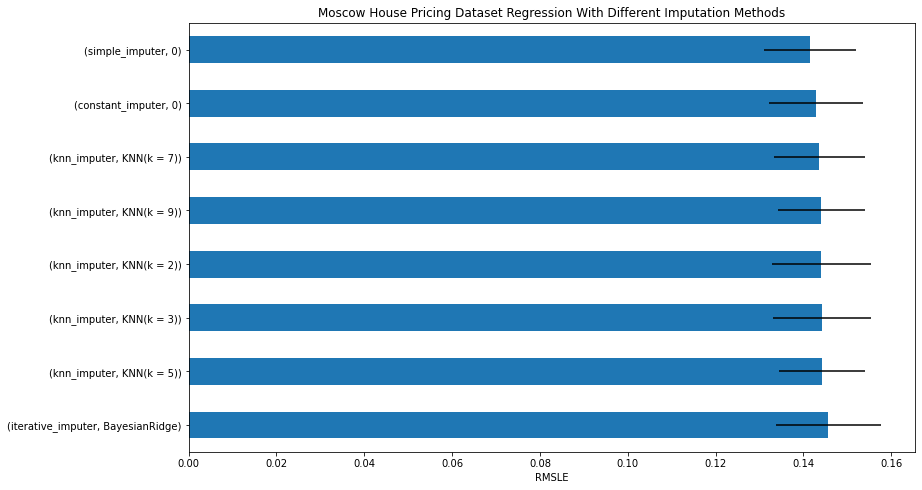

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Moscow House Pricing Dataset Regression With Different Imputation Methods")
ax.set_xlabel("RMSLE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=5)

As it can be seen above with the train data a simple imputation with mean for numerical features and most frequent values for categorical features yields the lowest error. 
Surprisingly, we discovered another behaiviour on the test data: A simple constant imputation with -999 on the test data outperforms the others in terms of RMSLE. Therefore we used this for our final submission on kaggle. As we impute all the missing value with -999 – a value which is not contained in the value set of any respective feature – our tree boosting models are able to deduce information from missing values. Apparently missing values in test data give a better indication for the real price.

### Plot Correlation
Plotting the correlation between features gives important information about which features are most important for predicting the target, but also insights into relationships between features.  

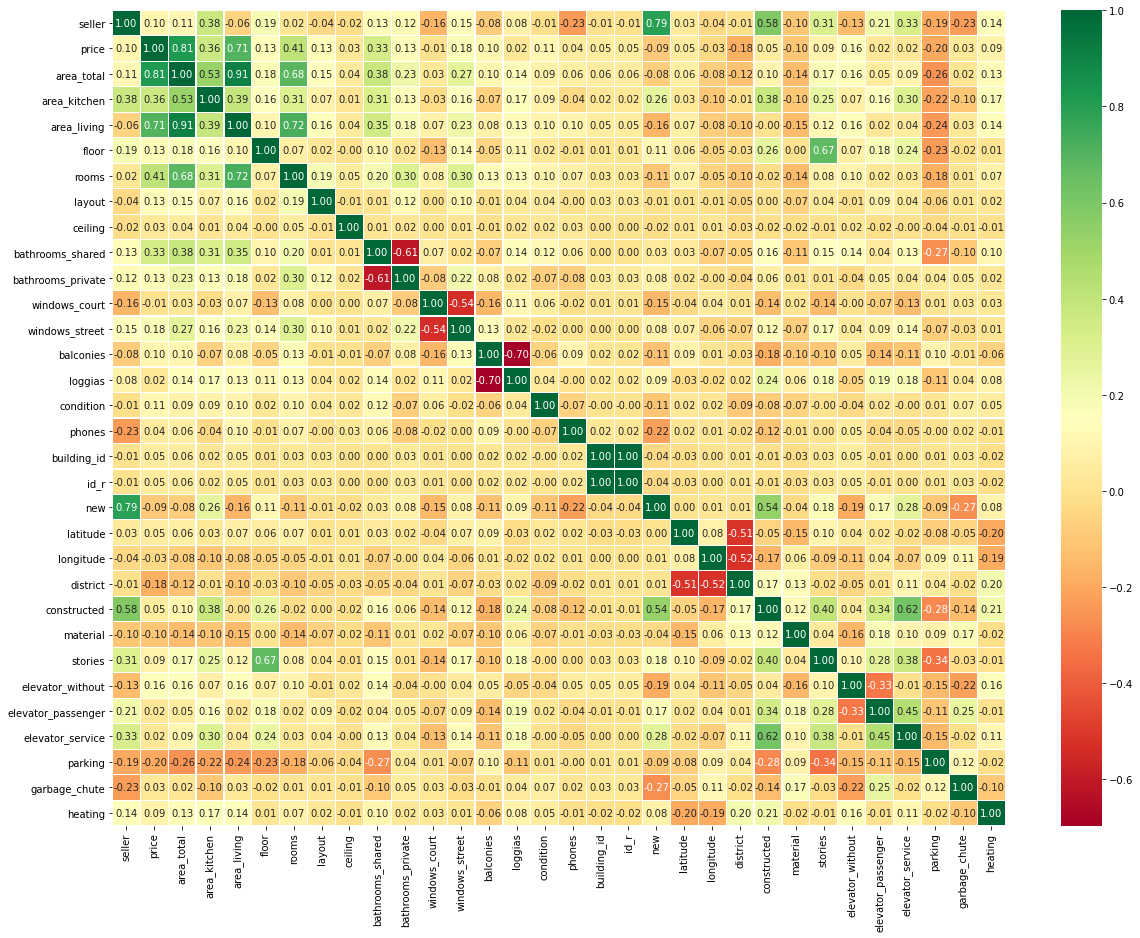

In [25]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

From this plot we can derive the following insights:
- The area-related features, especially total and living area, are highly correlated to the price. We expect them to be important.
- There is a considerable amount of features uncorrelated to the price. It might make sense to drop some of them to remove noise.
- There is strong negative correlation between balconies and loggias, as well as between windows_street and windows_court.
- There is also negative correlation between the two types of bathrooms, but because bathrooms_shared has a considerable negative correlation to the price, we should keep them separate.

How do the correlations in the training and the test set differ?

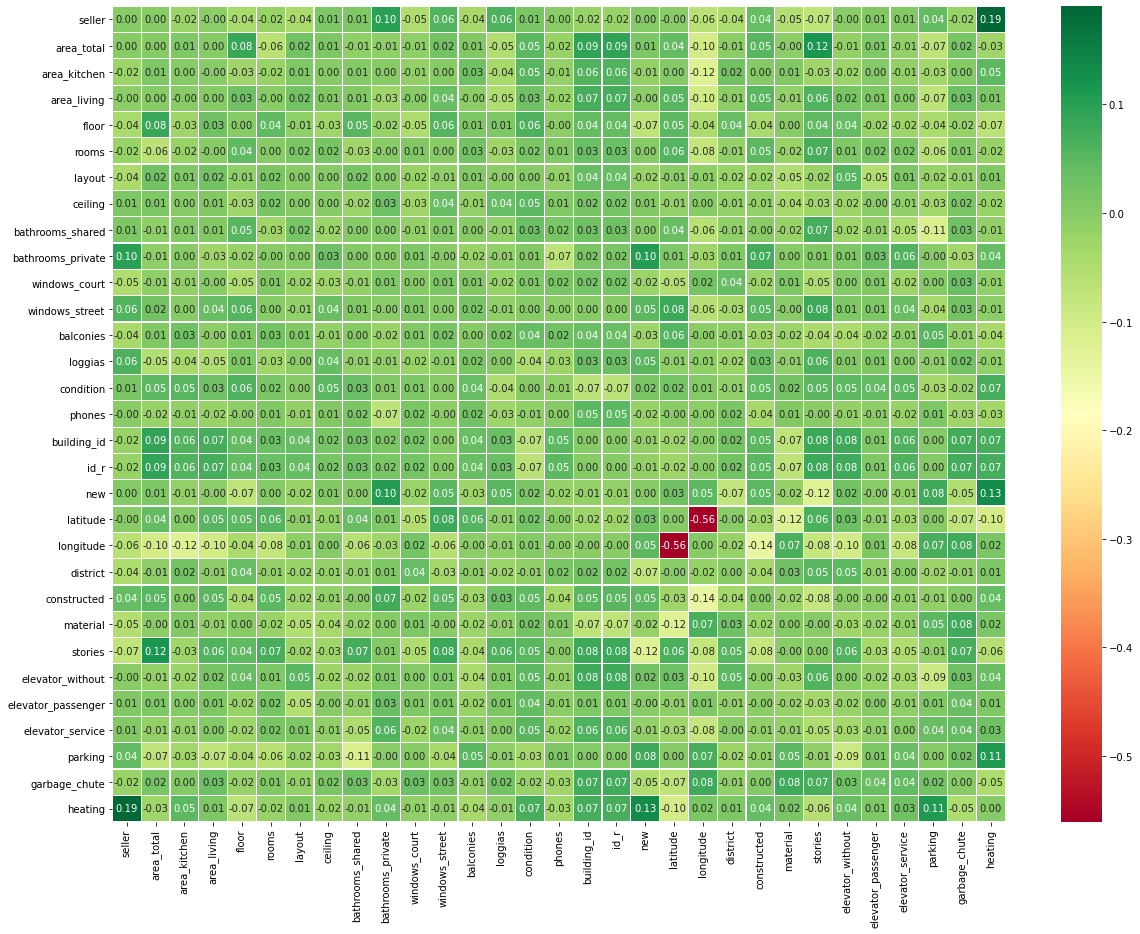

In [26]:
keys = train_df.keys().drop(["price"])
plt.figure(figsize=(20, 15))
sns.heatmap(train_df[keys].corr() - test_df[keys].corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

The correlations are largely similar, only a few comparatively larger differences appear between some features less correlated to the price, so this might be caused by noise. What strikes the eye is a very large difference in the coordinate features. This speaks for different locations of training and test set buildings.

### Feature Importance
To confirm the insights that the correlation plot gave us, we train a gradient boosting regressor on the full dataset. This allows us to look into the feature importances and make more educated decisions about which features to keep and which to drop. The below plot shows us how many times every feature has been split on during the tree-based gradient boosting process.

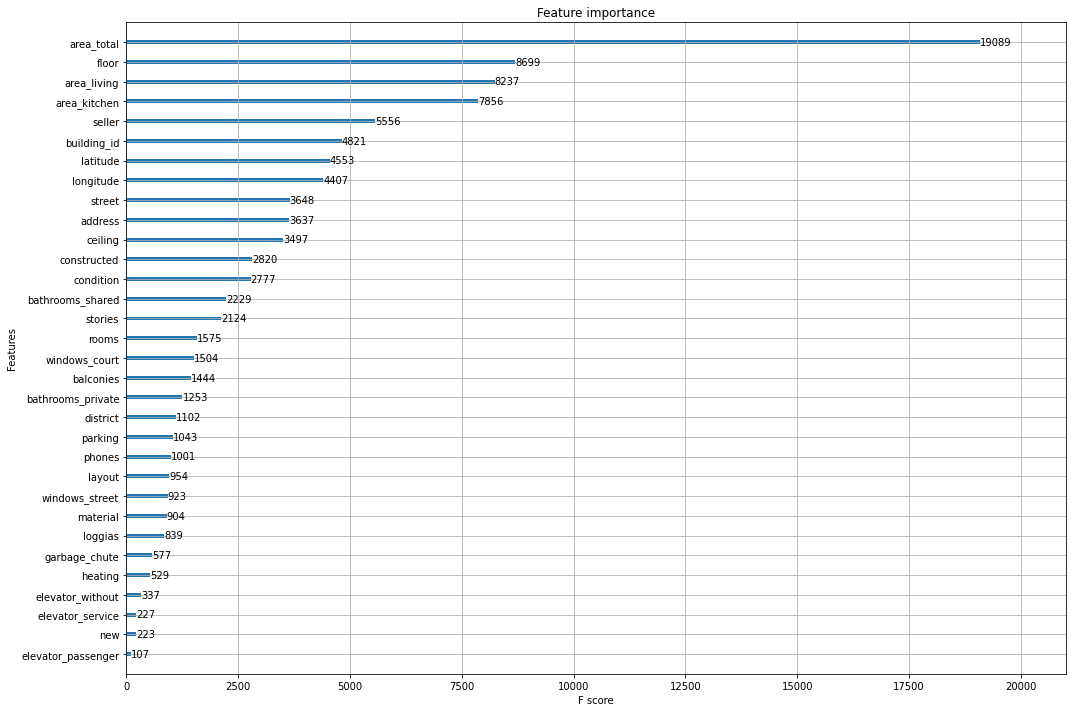

In [9]:
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plot_importance(model_xgb, ax=ax)

plt.tight_layout()

As expected after the correlation analysis, the area-related features of the apartment are the most important ones for the tree-boosting model. 

The floor exceeds our expectations in feature importance, as it was not as highly correlated to the price as the living area. We assume that the floor number is important since:
- It can be a good indicator for high priced luxury apartments high up in the building 
- Exluding luxury apartments, the ground and the highest floor may be less popular since they usually don't have a balcony. Within the paper mentioned in the beginning of this notebook, it is assumed that the highest floor may also suffer from water leakage when the roof is damaged and it may be to hot in summer if the roof is poorly insulated. On the other side the ground floor may be more noisy because of the entrance door and elevator, and there might be a lack of privacy.

The seller seems to be also an important indicator and we assume as reason that some of them are specialized on certain price segments of the house market and therefore sell houses in similar price ranges.

Furthermore it can be observed that location-related features like building_id, latitude, longitude, address, and street are also important for the price. This makes sense since the prices tend to be higher the closer the apartment is to the city center or in general if it is located in a wealthy living area. 



We decided to drop some of the less and non-important features as this can reduce noise and lead to better price predictions. We discovered that dropping the following features will lead to a lower RMSLE:

In [4]:
all_data = all_data.drop(["windows_court", "windows_street", "elevator_service", "elevator_passenger", "garbage_chute", 
        "layout", "parking", "heating", "elevator_without", "district", "phones", "building_id", "id_r", "material"], axis = 1)

### Exploration of Single Features and Data Cleaning

#### Coordinates
We noticed that in the test set there are coordinates far outside the Moscow city center. These are not present in the training set.

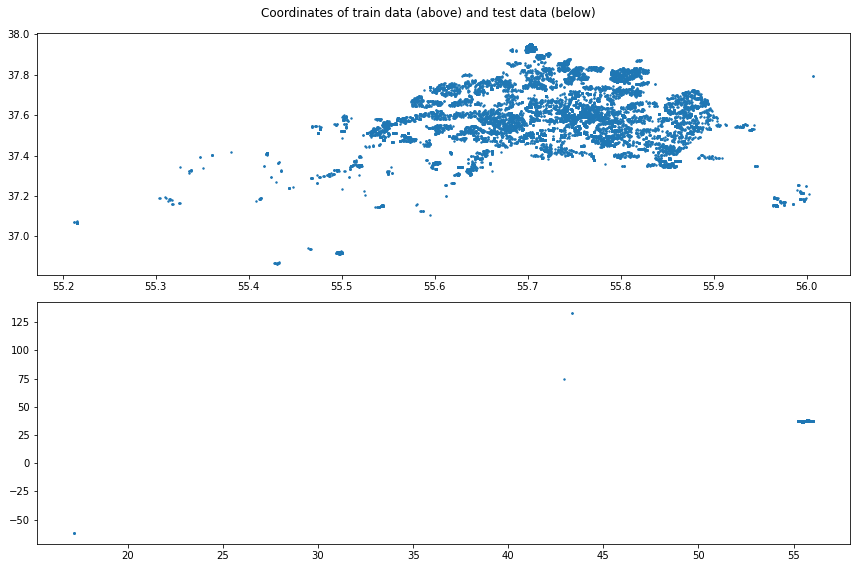

In [28]:
fig, axs = plt.subplots(2, figsize=(12, 8))
fig.suptitle("Coordinates of train data (above) and test data (below)")
axs[0].scatter(train_df.latitude, train_df.longitude, s=2)
axs[1].scatter(test_df.latitude, test_df.longitude, s=2)
plt.tight_layout()

So, with the help of the Google Maps, we corrected these coordinates.

In [4]:
# Merge features
all_data["street_and_address"] = all_data.street + " " + all_data.address

# Imputing coordinates outside of moscow and NaNs
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752

# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608

# Ordinal Encdoding for streets
all_data["street"] = LabelEncoder().fit_transform(all_data["street"])
all_data["street_and_address"] = LabelEncoder().fit_transform(all_data["street_and_address"])


Furthermore, we have noticed by plotting the correlation that the coordinates in training and test set are correlated very differently. Let's check, where the buildings are located: 

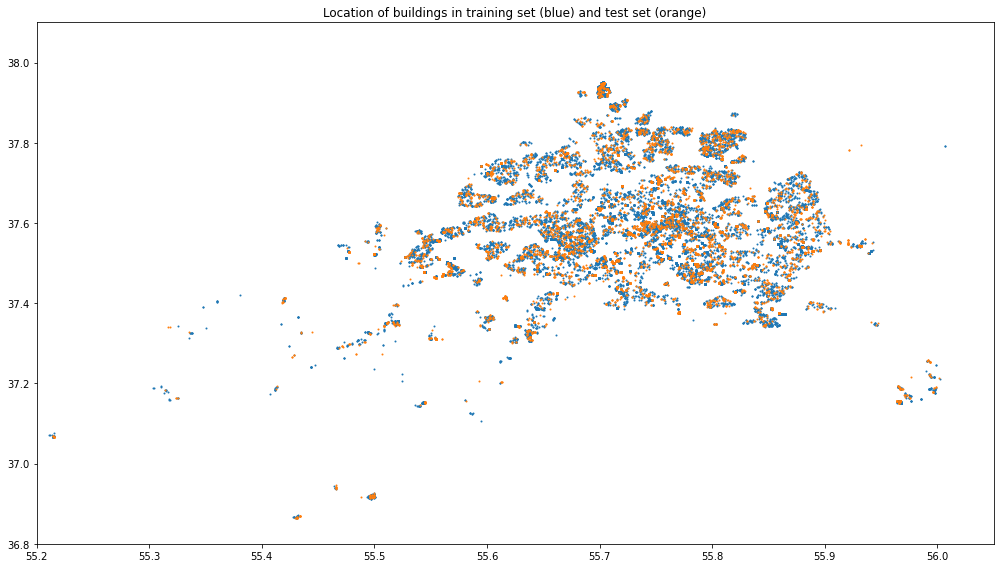

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(train_df.latitude, train_df.longitude, s=1)
plt.scatter(test_df.latitude, test_df.longitude, s=1)
plt.axis([55.2, 56.05, 36.8, 38.1])
plt.title("Location of buildings in training set (blue) and test set (orange)")
plt.tight_layout()

The plot does not proof it, but it could be the case that the apartments are generally not in the same place. It is confirmed by checking if there are any overlapping building IDs, which is not the case:

In [31]:
print("Amount of shared building IDs between training and test set: ", len(set(train_df.building_id).intersection(set(test_df.building_id))))

Amount of shared building IDs between training and test set:  0


Therefore, we tried to perform the splitting within cross-validation not only according to the price but also according to building ID, i.e. we used a StratifiedGroupKFold for local verification of our model before uploading to Kaggle. We hoped that in this way the local RMSLE would adjust to the leaderboard RMSLE. However, the local score was still quite different from the leaderboard score and on top didn't always move in the same direction after changes. This is why we decided to stay with a simple stratified split according to the price.

In [5]:
all_data = all_data.drop(["street_and_address", "address"], axis = 1)

We also dropped street_and_address again, as it will never be the same between train and test set. Address is not useful, too, as they can overlap between streets.

#### Ceiling

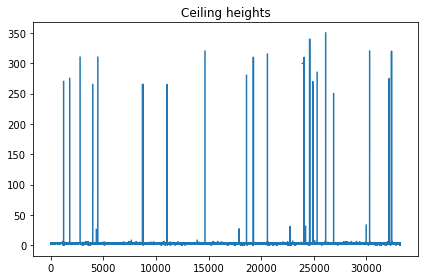

In [38]:
plt.plot(all_data.ceiling)
plt.title("Ceiling heights")
plt.tight_layout()

In [10]:
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling > 200]))
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))

# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling / 100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling / 10

Amount of ceilings higher than 200m:  31
Amount of ceilings between 25m and 200m:  8


As the plot above shows, there are several entries for ceilings which exceed hundeds of meters. We suspect that they arise from using different units for measurement, i.e. some sellers might provide this information in meters and others in centimeters or decimeters.
The ceilings are out of scale either by a factor of 100 or 10, so we tried to rescale them to have a reasonable value. However, this did not yield any improvement in RMSLE which is why we omitted this in the final solution.

#### Area
There are several entries in train and test set where the kitchen or living area exceed the total area of the apartment, as well as apartments with extraordinarily large or small total areas. To get a feel for this data, we plot it and check how many rows this applies to.

Amount of flats with total area > 1000 :  5
Amount of flats with total area < 10 :  2
Amount of flats with living area > total :  185
Amount of flats with kitchen area > total :  1


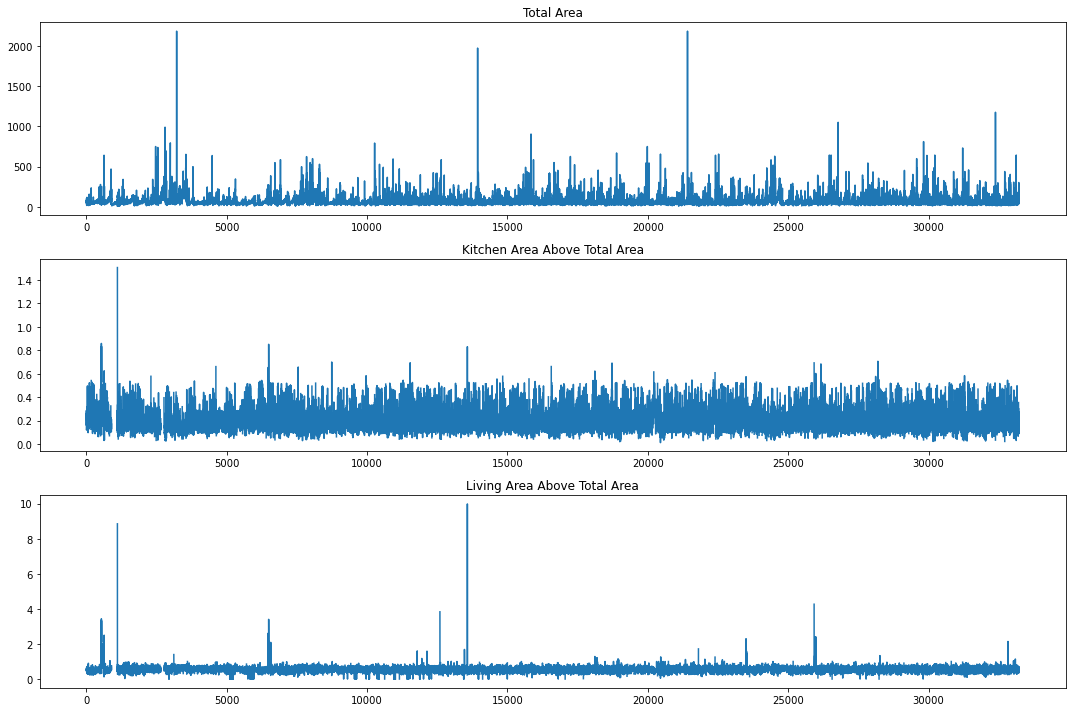

In [39]:
fig1, axs = plt.subplots(3, figsize=(15, 10))
axs[0].plot(all_data.area_total)
axs[0].set_title("Total Area")
axs[1].plot(all_data.area_kitchen/all_data.area_total)
axs[1].set_title("Kitchen Area Above Total Area")
axs[2].plot(all_data.area_living/all_data.area_total)
axs[2].set_title("Living Area Above Total Area")
plt.tight_layout()

print("Amount of flats with total area > 1000 : ", len(all_data.area_total[all_data.area_total > 1000]))
print("Amount of flats with total area < 10 : ", len(all_data.area_total[all_data.area_total < 10]))

print("Amount of flats with living area > total : ", len(all_data[all_data.area_living > all_data.area_total]))

print("Amount of flats with kitchen area > total : ", len(all_data[all_data.area_kitchen > all_data.area_total]))


We believed that the entries where the living and/or kitchen areas are larger than total area were just incorrectly specified in the advert and tried to clean those by setting the kitchen area to 1/3 of the total area and the living area to 3/5 of the total area. According to the the paper mentioned in the beginning, these are the standard ratios of living and kitchen space compared to the total area of the apartment. 

In [12]:
wrong_kitch_sq_index = all_data['area_kitchen'] > all_data['area_total']
all_data.loc[wrong_kitch_sq_index, 'area_kitchen'] = all_data.loc[wrong_kitch_sq_index, 'area_total'] * 1 / 3

wrong_life_sq_index = all_data['area_living'] > all_data['area_total']
all_data.loc[wrong_life_sq_index, 'area_living'] = all_data.loc[wrong_life_sq_index, 'area_total'] * 3 / 5

However, in our final solution this cleaning did not show to be effective. Further investigation showed that the apartments where the living and/or kitchen area is larger than the total area, 
sometimes share exactly the same kitchen and living area value and also have shared bathrooms. This is why we suspect that the kitchen space and parts of the living space may refer to common areas. We discarded this correction, as those entries may provide valuable information to the model by identifying apartments with common kitchens and living areas. This was confirmed by a submission, as the score with "corrected" sizes was worse than the one with simply keeping it this way.

In [40]:
print(all_data[["area_total", "area_kitchen", "area_living", "bathrooms_shared", "bathrooms_private"]][all_data.area_living > all_data.area_total].head())
print("Amount of flats with living > total and shared bathrooms:", len(all_data[(all_data["area_living"] > all_data["area_total"]) & (all_data["bathrooms_shared"] > 1)]))

     area_total  area_kitchen  area_living  bathrooms_shared  \
id                                                             
514        37.0          20.0         80.0               2.0   
515        32.0          20.0         80.0               2.0   
517        77.2          20.0         80.0               2.0   
523        77.0          20.0         80.0               2.0   
536        23.3          20.0         80.0               2.0   

     bathrooms_private  
id                      
514                0.0  
515                0.0  
517                0.0  
523                0.0  
536                0.0  
Amount of flats with living > total and shared bathrooms: 156


#### Rooms
We checked if there are apartments with zero rooms or bathrooms:

Amount of apartment with 0 rooms:  0
Amount of apartment with 0 bathrooms:  0


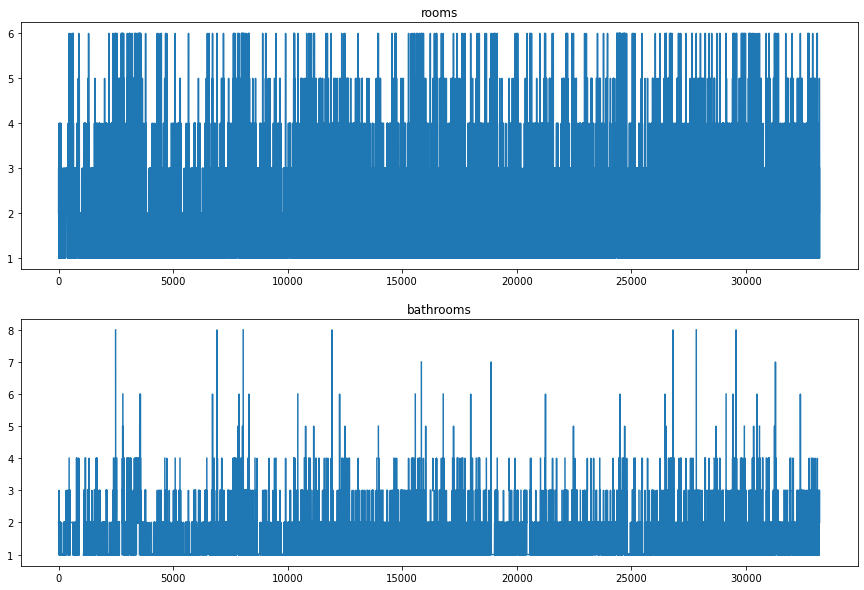

In [41]:
fig1, axs = plt.subplots(2, figsize=(15,10))
axs[0].plot(all_data.rooms)
axs[0].set_title("rooms")
axs[1].plot(all_data.bathrooms_private + all_data.bathrooms_shared)
axs[1].set_title("bathrooms")

print("Amount of apartment with 0 rooms: ", len(all_data.rooms[all_data.rooms==0]))
print("Amount of apartment with 0 bathrooms: ", len(all_data[all_data.bathrooms_shared+all_data.bathrooms_private==0]))

#### Floor

We also investigated if the specified floor level of any apartment is flawed. 
We found that some apartments are supposed to lie on a higher floor than the maximum floor of the building. As this cannot be the case, we tried to correct set the floor value of those to the stories value of the building. In the final solution this correction was not applied as it performed worse with it.

In [15]:
print("Amount of apartment with 0 floors: ", len(all_data[all_data.stories==0]))
print("Amount of apartment with floor bigger than stories: ", len(all_data[all_data.floor>all_data.stories]))

wrong_floor = all_data['floor'] > all_data['stories']
all_data.loc[wrong_floor, 'floor'] = all_data.loc[wrong_floor, 'stories']

Amount of apartment with 0 floors:  0
Amount of apartment with floor bigger than stories:  414


## Feature Engineering


### Features Included in the Final Model

In addition to data cleaning und discarding features of low importance, we created new features of which some improved our model. By considering the question what makes an apartment more or less expensive, we came to the conclusion that the location plays one of the most important roles.

#### Distance to City Center
Therefore, we first added a feature which describes the distance of the apartment to the city center. In this way we extract more useful information from the given coordinates.
First, we define a distance metric, the haversine distance. It calculates the distance between two coordinates while also considering the earth's curvature. The default arguments for lat2 and lng2 are the latitude and longitude of Moscow's city center defined by the red square.

In [6]:
def haversine_array(lat1, lng1, lat2 = 55.752, lng2 = 37.617):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [7]:
all_data['center_distance'] = haversine_array(all_data['latitude'], all_data['longitude'])

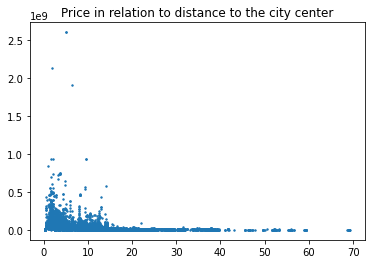

In [47]:
plt.scatter(all_data.center_distance, all_data.price, s=2)
plt.title("Price in relation to distance to the city center");

As we can see, generally, the most expensive apartments tend to be near the city center.

#### Distance to Closest Metro Station
A second important indicator for the house price may be the distance to the nearest metro station, as many people who don't have cars rely on it for personal mobility. We got the locations of all metro stations within Moscow from Wikipedia (https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) and created a csv file. Using this, we added an additional feature to every sample, indicating the distance to the closest metro station from the apartment.

In [8]:
bulding_locs = np.asarray(list(zip(all_data['latitude'], all_data['longitude'])))
metro_locs = np.asarray(list(zip(metro_stations['latitude'], metro_stations['longitude'])))
closest_metro_dist = np.min(haversine_distances(bulding_locs, metro_locs), axis=1)
all_data['closest_metro'] = closest_metro_dist

#### Mapping each Apartment to its Subarea

The last feature we added based on the coordinates of the building was the district. We assigned every apartment to its district (or raion) using geographical data which was provided in an old kaggle competition (https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/32201). For this task we used geopandas.

In addition, we added a second similar feature which mapped each apartment to its subarea based on the euclidian distance to the center of the nearest subarea. This improves the price prediction additionally and we believe the reason could be that apartments which are located close to its subarea border sometimes share more characteristics with a neighboring subarea.

Lastly, we applied PCA on this different but correlated mappings to build a new subarea-related feature.

In [9]:
# Add nearest sub_area based on its center
bulding_locs = np.asarray(list(zip(all_data['latitude'], all_data['longitude'])))
sub_area_locs = np.asarray(list(zip(sub_area_centers['longitude'], sub_area_centers['latitude'])))
closest_sub_idx = np.argmin(haversine_distances(bulding_locs, sub_area_locs), axis=1)
all_data["sub_area_"] = sub_area_centers['sub_area'].iloc[closest_sub_idx].values

# Mapping each building to its real sub_area
geo_df = gp.GeoDataFrame(all_data, geometry=gp.points_from_xy(all_data.longitude, all_data.latitude))
geo_df.crs = "EPSG:4326"
sub_areas.crs = "EPSG:4326"
all_data = gp.sjoin(sub_areas, geo_df, how='right', predicate='contains')
all_data = all_data.drop(["DISTRICT", "geometry", "OKATO", "OKTMO", "OKATO_AO", "index_left"], axis=1)

# Ordinal Encoding for both sub_area variants
all_data["sub_area"] = LabelEncoder().fit_transform(all_data['sub_area'])
all_data["sub_area_"] = LabelEncoder().fit_transform(all_data['sub_area_'])

# PCA transforming the two variants above
pca = PCA(n_components=1)
all_data["sub_area_pca"] = pca.fit_transform(all_data[["sub_area", "sub_area_"]]).squeeze()

#### Average Squaremeter Price in the Neighborhood

Using the nearest neighbour algorithm BallTree, we calculate for each apartment the average square meter price of the closest 300 apartments nearby and add this as a new feature.

In [10]:
tree = BallTree(all_data[["latitude", "longitude"]])
dist, ind = tree.query(all_data[["latitude", "longitude"]], k=300)

mean_sqm_price = []
mean_subarea_price = []

for rows in ind:
    mean_sqm_price.append(np.nanmean(all_data['price'].iloc[rows] / (all_data['area_total'].iloc[rows])))
    mean_subarea_price.append(np.nanmean(all_data['price'].iloc[rows]))

all_data["mean_sqm_price"] = mean_sqm_price

Finally, we plot the feature importance of the newly developed features together with the old ones. It can be seen that most of them show a high impact during construction of the decision trees.

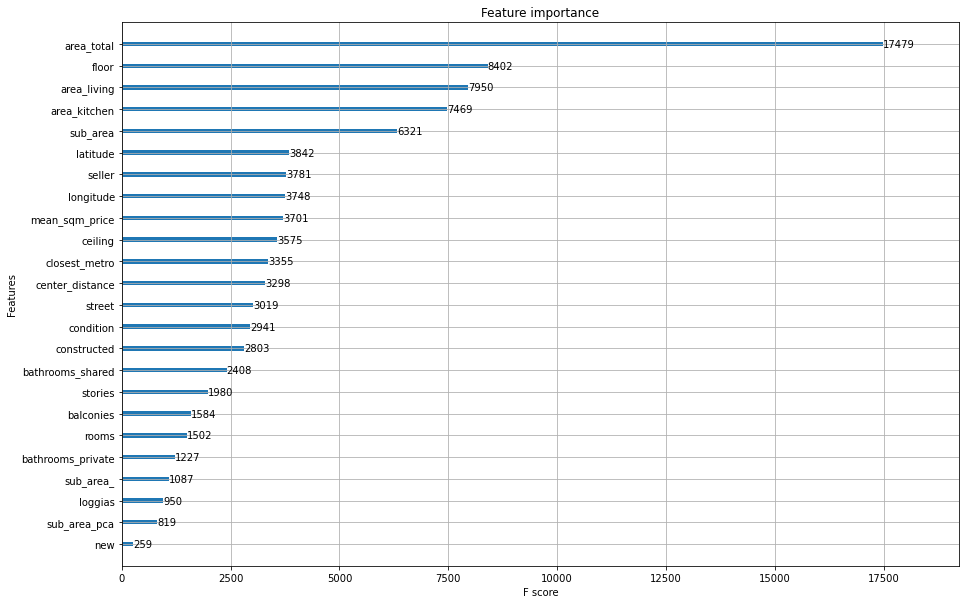

In [87]:
X = all_data[0:23285].drop(["price"], axis = 1)
y = all_data[0:23285].price
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_importance(model_xgb, ax=ax);

### Features Discarded in the Final Model

#### Average Price per District
This was our predecessor to the BallTree-based average square-meter price prediction, but it did not show very much predictive power, as it was completely collinear to the district.

In [ ]:
mean_price = train_df.groupby('district').mean().reset_index()[['district', 'price']]
train_df = train_df.merge(mean_price, how='left', on='district', suffixes=('', '_avg'))
test_df = test_df.merge(mean_price, how='left', on='district').rename(columns={'price' : 'price_avg'}).set_index(test_df.index)

#### Floor distance
From the paper we read, we found out that the number of the floor could be important, in particular it is better to be in the higher floors. That's why we added two features:
- floor_from_top: how many floors are in the middle between the apartment and the last floor
- floor_over_stories: the percentage of the height of the floor over the total height 

In [ ]:
all_data['floor_from_top'] = all_data['stories'] - all_data['floor']
all_data['floor_over_stories'] = all_data['floor'] / all_data['stories']

#### Construction year
According to Ruslan Khalitov, the data set was created in 2018. We found that some buildings have a construction date located in the future. This applies to about one third of all data.

In [50]:
print("Oldest building was built:", int(min(all_data.constructed)))
print("Newest building will be built:", int(max(all_data.constructed)))
print("Amount of buildings unfinished at data set creation: ", len(all_data[all_data.constructed > 2018]))

Oldest building was built: 1855
Newest building will be built: 2023
Amount of buildings unfinished at data set creation:  11091


We tried to introduce a new feature indicating whether the building is already constructed or will be constructed in the future. So we added the following features:
- age_of_house_before_sale: How many ages separate the selling and the construction if the house is not built yet
- sale_before_build: Boolean that checks if the house is not built yet

In [ ]:
all_data['age_of_house_before_sale'] = np.where((2018 - all_data['constructed'] > 0), 2018 - all_data['constructed'], 0)
all_data['sale_before_build'] = ((2018 - all_data['constructed']) < 0).astype(int)

#### Area percentage
The percentage of how much of the total area is dedicated to the kitchen or to the living areas may be important. So we added to features to indicate the percentage of kitchen area and living area over total area.

In [ ]:
all_data['area_kitchen_percentage']= all_data['area_kitchen'] / all_data['area_total']
all_data['area_living_percentage']= all_data['area_living'] / all_data['area_total']

#### Subarea Related Features
We tried to include some district-related information from the other kaggle competition dataset mentioned in the beginning. Concretely, we tried to add the following features to each apartment:
- Number of pre-school instituitons in the district
- Number of high schools in the district of the top 20 best schools in Moscow
- Number of healthcare centers in the district
- Number of higher education institutions in the district in the top ten ranking of the Federal rank
- Number of objects of cultural heritage in the district
- Number of malls and shopping centres in the district
- Share of brick buildings in the district

These features should serve to identify more favourable apartments and therefore more costly apartments. For example if an apartment lies in a district with many shopping centers or has some of the top universities nearby, it is likely that the price is also high.

In [ ]:
all_data['preschool_education_centers_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().preschool_education_centers_raion)
all_data['school_education_centers_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().school_education_centers_raion)
all_data['school_education_centers_top_20_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().school_education_centers_top_20_raion)
all_data['healthcare_centers_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().healthcare_centers_raion)
all_data['university_top_20_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().university_top_20_raion)
all_data['culture_objects_top_25_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().culture_objects_top_25_raion)
all_data['shopping_centers_raion'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().shopping_centers_raion)
all_data['build_count_brick'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().build_count_brick)
all_data['mean_green_area'] = all_data['sub_area'].map(sberbank_data.groupby("sub_area").mean().green_zone_part)

In the final model we discovered that many of the features above 'cancel' eachother out and the error is fluctuating depending on which on these features are included. We didn't find a combination which improves our prediction which is why we omitted these features in our final solution. This is likely because they are collinear to the subareas. Only the mean green area we actually kept.

#### PCA

We tried out to use PCA on correlated features. We wanted to decorrelate correlated features and add them to the dataset. None of the following attempts brought an improvement to the leaderboard score.

In [88]:
pca = PCA(n_components=2)
loc_keys = ["sub_area", "sub_area", "center_distance", "closest_metro"]
loc_pca = StandardScaler().fit_transform(all_data[loc_keys])
all_data[["sub_area_pca1", "sub_area_pca2"]] = pca.fit_transform(loc_pca).squeeze()

pca = PCA(n_components=1)
area_keys = ["area_living", "area_total", "area_kitchen"]
area_pca = StandardScaler().fit_transform(all_data[area_keys])
all_data["area_pca"] = pca.fit_transform(loc_pca).squeeze()

## Analyzing model performance

We stated earlier that cross validation with splitting on building_ids and stratifying on price did not produce a cross validation scheme in line with submission performance. Let's analyze this further. The following cell performs this cross validation with a log-transformed lgbm and saves the predictions on the validation set and the respective errors in a new DataFrame. We also add a row that tells us by what factor the price differs from what one would get by multiplying the mean square-meter price in the cluster with the total area of the apartment.

In [11]:
all_data.fillna(-999, inplace = True)

In [12]:
building_ids = train_df[0:23285].building_id
y = all_data[0:23285].price
X = all_data[0:23285].drop(["price"], axis = 1)

model_lgbm = LGBMRegressor(n_estimators=1200, max_depth=7)
trans_lgbm = TransformedTargetRegressor(regressor=model_lgbm, func=np.log1p, inverse_func=np.expm1)
cv = StratifiedGroupKFold(shuffle = True, random_state = 429)

errors = []
error_analysis_df = 0
i = 0

for train_idx, val_idx in cv.split(X, np.log(y).round(), groups=building_ids):
    
    X_train_, y_train_ = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    trans_lgbm.fit(X_train_, y_train_)
    pred = trans_lgbm.predict(X_val)
    errors.append(rmsle(y_val, pred))
    
    X_val["ground_truth"] = y_val
    X_val["prediction"] = pred
    X_val["error"] = pred/y_val
    
    if i == 0:
        error_analysis_df = X_val
    else:
        error_analysis_df = pd.concat([error_analysis_df, X_val], axis = 0)
        
    print("Error: ", errors[-1])
    i = i+1
        
print("Mean error cv: ", np.mean(errors))

/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:876: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error:  0.22384222670579929
Error:  0.19533567592237144
Error:  0.19859906169309266
Error:  0.17213172308716057
Error:  0.1870015772572791
Mean error cv:  0.19538205293314062


There are big fluctuations in performance between the iterations of cross validation. When looking at the rows where the error is larger than 2, so the model predicted twice the actual price, it catches the eye that there are many entries with the same distance to the city center. It appears as though the majority of the error stems from apartments in the same building.

In [14]:
show = 5
error_analysis_df["mean_sqm_times_area"] = error_analysis_df["mean_sqm_price"]*(error_analysis_df["area_total"])
error_analysis_df["diff_to_mean_sqm_times_area"] = (error_analysis_df["mean_sqm_price"]*(error_analysis_df["area_total"]))/error_analysis_df["ground_truth"]
print(error_analysis_df[error_analysis_df.error > 2].head(show))

      sub_area  seller  area_total  area_kitchen  area_living  floor  rooms  \
id                                                                            
299        133  -999.0        63.7          10.7         30.6    2.0    2.0   
1107       142  -999.0         9.3          14.0         82.3    3.0    1.0   
1138       142  -999.0        10.0           1.4          6.5    2.0    1.0   
1139       142  -999.0        11.2           1.5          7.4    5.0    1.0   
1448       106     3.0        47.4          18.2         15.2   32.0    1.0   

      layout  ceiling  bathrooms_shared  ...  center_distance  closest_metro  \
id                                       ...                                   
299      1.0   -999.0               0.0  ...         1.752367       0.001833   
1107     1.0      3.1               2.0  ...        13.355810       0.007307   
1138  -999.0      2.5               1.0  ...        13.355810       0.007307   
1139  -999.0      2.5               1.0  ...  

In [13]:
print("Amount of rows with error>2 and center_distance=3.18: ", len(error_analysis_df[(error_analysis_df.error > 2) & (error_analysis_df.center_distance.between(2.59, 2.6))]))

Amount of rows with error>2 and center_distance=3.18:  91


In [15]:
drop_idx = error_analysis_df[(error_analysis_df.error > 2) & (error_analysis_df.center_distance.between(2.59, 2.6))].index
X_ = X.drop(index = drop_idx)
y_ = y.drop(index = drop_idx)
building_ids_ = building_ids.drop(index = drop_idx)

for train_idx, val_idx in cv.split(X_, np.log(y_).round(), groups=building_ids_):
    
    X_train_, y_train_ = X_.iloc[train_idx], y_.iloc[train_idx]
    X_val, y_val = X_.iloc[val_idx], y_.iloc[val_idx]
    trans_lgbm.fit(X_train_, y_train_)
    pred = trans_lgbm.predict(X_val)
    errors.append(rmsle(y_val, pred))
    
    print("Error: ", errors[-1])

/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:876: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error:  0.18854058615659405
Error:  0.18363773602084238
Error:  0.18151605356438746
Error:  0.200262652926911
Error:  0.1797487614110946


The fluctuations are now much less. We tried training our model without these entries, as well as scaling the ground truth of them because we suspected the prices were faulty. In the Sberbank-competition, it was mentioned, that extremely low prices can be due to tax evasion:
- https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/33887

Our attempts, however, did not improve the submission score. We sticked to regular KFold cross validation without splitting on buildings, as it proved to be a more reliable indicator of the submission score. It was still far from perfect. We did not succeed to find a cross validation technique which resembled the true submission scores properly. As can be seen above, the scores are far worse then our leaderboard scores - then again, using regular KFold validation they were much too low, because information about the buildings the apartments are in leakes from the validation set into the training set.

## Final Model for Price Prediction

### Encoding of Categorical Variables
After cleaning the data and creating new features, we encoded the categorical variables. This includes the following features:
condition, seller, new, sub_area, constructed, street_and_address. In general One-Hot Encoding should be superior to Ordinal Encoding for categorical variables which have no specific ordering. Despite of this, the performance of our regressor improved when using OrdinalEncoding for the categorical features. We did also play around with the built-in encoders of lgbm and catboost, but they neither showed an improvement, so we sticked to a simple Ordinal Encoding.


### Stacking Model
For our final model, we stacked the following models:
- LightGBM
- CatBoost
- XGBoost
- ExtraTreesRegressor
- GradientBoostingRegressor

This yields 5 meta features related to the price of the apartment and allows to use the strength of each individual estimator. We used ridge regression to predict the final prices from the meta features as it mitigates the problem of multicolinearity between them. This is important since all the outcoming meta features already give a decent estimation of the real price value and are therefore highly correlated.  

In [16]:
model_lgbm = LGBMRegressor(max_depth=6, n_estimators=1200, learning_rate=0.1)
model_xgb = XGBRegressor(n_estimators=1500, max_depth=6, learning_rate=0.1)
model_cat = CatBoostRegressor(iterations=1000, depth=7, learning_rate=0.1, silent=True)
model_extra = ExtraTreesRegressor(n_estimators=1000, random_state=42)
model_hist = HistGradientBoostingRegressor(max_depth=7, max_iter=1000, learning_rate=0.1, random_state=42)
model_ada_lgbm = AdaBoostRegressor(base_estimator = model_lgbm, n_estimators=50, random_state = 42)

final_model = RidgeCV()

base_learners = [
    ('xgb_tree', model_xgb),
    ("lgbm", model_lgbm),
    ('catboost', model_cat),
    ('extra_trees', model_extra),
    ('hist_boost', model_hist),
    ("ada_lgbm", model_ada_lgbm)
]

model_stacking = StackingRegressor(estimators=base_learners, final_estimator=final_model, cv=5)
trans_stacking = TransformedTargetRegressor(regressor=model_stacking, func=np.log1p, inverse_func=np.expm1)

### Local Verification of RMSLE
The hyperparameters of the individual models above were all optimized beforehand with manual tweaking. We used a 5-fold cross-validation to verify any improvement when changing the hyperparameters, cleaning data, or adding new features. The splitting in each fold was performed according to the price of the apartments.

In [17]:
X = all_data[0:23285].drop(["price"], axis = 1)
y = all_data[0:23285].price

cv = StratifiedKFold(shuffle=True)
model = TransformedTargetRegressor(regressor=model_lgbm, func=np.log1p, inverse_func=np.expm1)

errors = []

for train_idx, val_idx in cv.split(X, np.log(y).round()):

    X_train_, y_train_ = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model.fit(X_train_, y_train_)
    pred = model.predict(X_val)
    errors.append(rmsle(y_val, pred))

    print("Error: ", errors[-1])
print("Mean error: ", np.mean(errors))

/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error:  0.124143960711048
Error:  0.13150706640782403
Error:  0.12765078495174773
Error:  0.12602492599161524
Error:  0.1316276282463433
Mean error:  0.1281908732617157


### LIME
For explanation our model, we use LIME. This way, for every row, we can get an insight into why the model predicted the way that it did.

In [18]:
X_test = all_data[23285:len(all_data)].drop("price", axis = 1)
X_train = all_data[0:23285].drop("price", axis = 1)
y_train = all_data[0:23285].price
trans_stacking.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=StackingRegressor(cv=5,
                                                       estimators=[('xgb_tree',
                                                                    XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                                                 colsample_bynode=None,
                                                                                 colsample_bytree=None,
                                                                                 gamma=None,
                                                                                 gpu_id=None,
                                                                                 import

/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/cip/2016/ny70konu/.local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


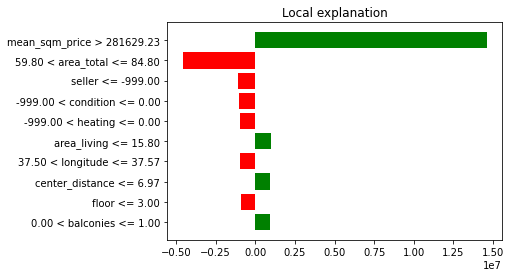

In [20]:
idx_to_explain = 0
explainer = lime_tabular.LimeTabularExplainer(np.asarray(X_train), mode="regression", feature_names=X.keys().values)
explanation = explainer.explain_instance(np.asarray(X_test.iloc[idx_to_explain]), trans_stacking.predict)
fig = explanation.as_pyplot_figure()